<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/Qiskit_Runtime_Sampler_Primitives_QPU_quasi_dists_mkbahk_20241010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

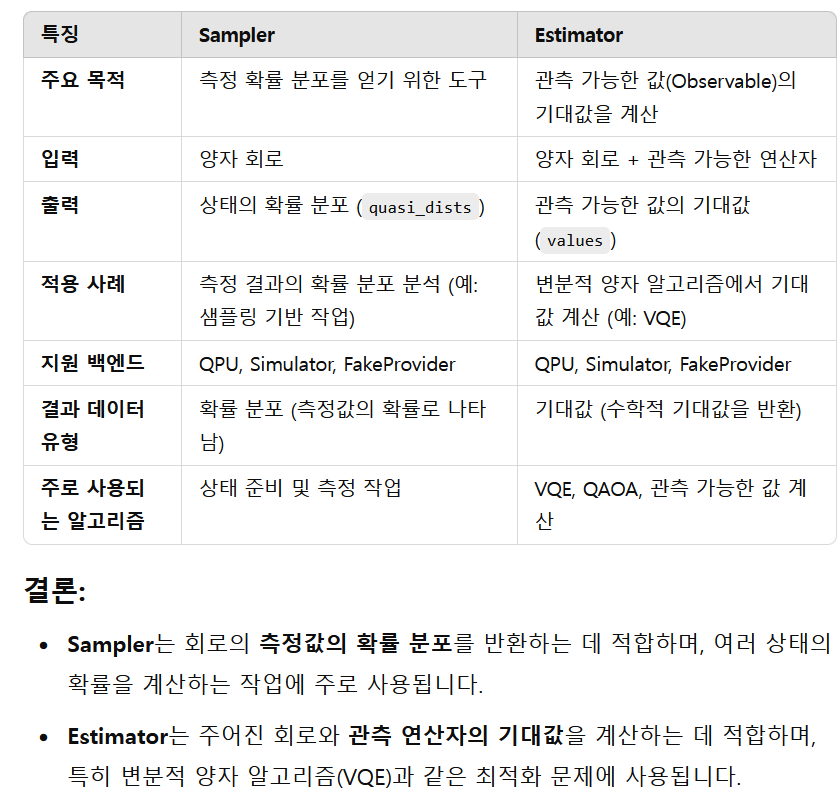

In [1]:
### Qiskit 설치: Windows, 클라우드 환경 ###
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-ibm-runtime
%pip install qiskit-transpiler-service
%pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.3 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=515f57618587dea14e1574a4711953736f64ff8db6d7d96df4bb76f1da29166f
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%pip show qiskit qiskit-ibm-runtime qiskit-aer

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime, qiskit-qasm3-import, qiskit-transpiler-service
---
Name: qiskit-ibm-runtime
Version: 0.30.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: ibm-platform-services, numpy, pydantic, python-dateutil, qiskit, requests, requests-ntlm, urllib3, websocket-client
Required-by: 
---
Name: qiskit-aer
Version: 0.15.1

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import Estimator, Sampler, StatevectorSampler, PrimitiveJob

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator, Session, Options
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.visualization import plot_histogram

In [4]:
# Connecting runtime account
service = QiskitRuntimeService(channel="ibm_quantum", token="7901a13d659a804b7dc1ec1d7c00c2d729636c4ee20eabe6c916e3e94e9d80fd0203795da14b64e8c48923ad2e2e3bbad72f1bebb95b5701126d01b4d3fae122")
#service.save_account(channel="ibm_quantum", token="YOUR_API_TOKEN")
#backends = service.least_busy(min_num_qubits=2)
#service.backends("ibm_brisbane")
backends=service.backends()
print(backends)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


In [5]:
backend=backends[0]
print(backend)

<IBMBackend('ibm_brisbane')>


In [6]:
# Bell 상태 생성 회로 작성
qc = QuantumCircuit(2, 2)
qc.h(0)           # 큐빗 0에 Hadamard 게이트
qc.cx(0, 1)       # 큐빗 0에서 큐빗 1로 CNOT 게이트
qc.measure([0, 1], [0, 1])  # 두 큐빗을 측정

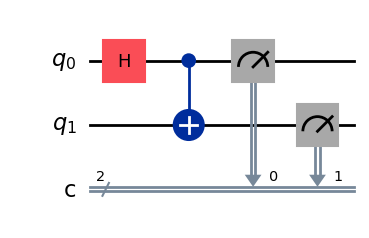

In [7]:
qc.draw('mpl')

In [8]:
sampler = Sampler(backend)
#sampler = AerSampler()

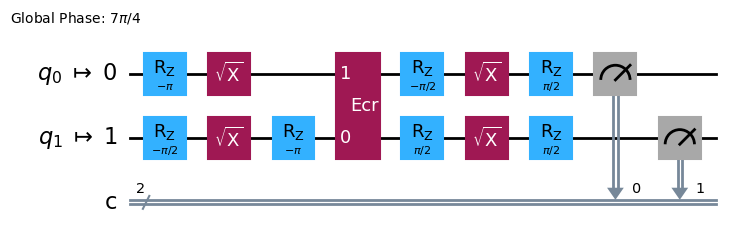

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

Qiskit-runtime-Service는 이전의 확률분포 반환에서 추가적으로 데이터를 반환하는 두 가지 방법을 제공합니다.
1.   측정하기로 선택한 큐비트 집합에 대한 확률 분포

```
# 회로 실행 및 결과 얻기
job = sampler.run(circuit)
result = job.result()
counts = result.quasi_dists[0]
# 결과 출력
print(counts)
```

2.   관측 가능한 값의 기대값

```
# 회로 실행 및 결과 얻기
job = estimator.run(observable, circuit)
result = job.result()
expectation_value = result.values[0]
# 결과 출력
print(expectation_value)
```
##?? Real QPU는 Sampler Primitive에서 확률분포를 지원하지 않음.

In [10]:
pub = (isa_circuit)
job_sampler = sampler.run([pub], shots=10000)


### Don't change any code past this line ###

result_sampler = job_sampler.result()

# execute the quantum circuit
quasi_dists = result_sampler.quasi_dists[0]
print(quasi_dists)

AttributeError: 'PrimitiveResult' object has no attribute 'quasi_dists'

In [ ]:
from qiskit.visualization import plot_histogram # Import plot_histogram
plot_histogram(quasi_dists)